# The Deterministic Cake Eating Problem - Value Function Iteration with Interpolation Solution
### by [Jason DeBacker](http://jasondebacker.com), June 2018
This Jupyter notebook illustrates how to solve the deterministic cake eating problem using interpolation with value function iteration (VFI).

## The Problem:

$$V(w)=\max_{c} u(c)+\beta V(w'), \forall w\in[0,\bar{w}]$$

or, substituting in the law of motion: $w' = w - c$,

$$V(w)=\max_{0\leq w' \leq w}u(w-w')+\beta V(w'), \forall w$$

The unknowns in this system are functions: The value function, $V(w)$, and the policy function, $c = \phi(w)$ (or, equivalently, $w' = p(w)$).

## The Solution:

We'll solve this problem with value function iteration (VFI).  With this method, we'll use an iterative procedure to converge to a fixed point in function space, the true value function, $V(w)$.  

The computational algorithm for VFI is as follows:

1. Create a discrete grid of the state variable, $w$
2. Make an initial guess at the value function, $V_{0}(w)$
    * This will be a value for each point in the state space
3. Perform the operation:
$$TV(w) = \max_{w'}u(w-w') + \beta V_{0}(w')$$
4. Update the guess at the value function: $V_{1}(w) = TV(w)$
5. Repeat this process:
$$V_{i+1} \ (w) = TV(w) = \max_{w'}u(w-w') + \beta V_{i}(w)$$
6. Stop when, $|V_{i+1} \ (w)-V_{i}(w)|<\varepsilon$, where $\varepsilon$ is a small number.



In [1]:
# Import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.optimize import fminbound
import scipy.optimize as opt

# to print plots inline
%matplotlib inline

## Step 1: Set parameters and create grid for state space

Parameters:
* $\beta$ = rate of time preference
* $\sigma$ = coefficient of relative risk aversion (if $\sigma = 1$, $u(c)=log(c)$), parameter describes the curvature of the utility function

In [2]:
beta = 0.95
sigma = 1.0
R = 1.0 / beta

'''
------------------------------------------------------------------------
Create Grid for State Space    
------------------------------------------------------------------------
lb_w      = scalar, lower bound of cake grid
ub_w      = scalar, upper bound of cake grid 
size_w    = integer, number of grid points in cake state space
w_grid    = vector, size_w x 1 vector of cake grid points 
------------------------------------------------------------------------
'''
lb_w = 0.1 
ub_w = 1.0 
size_w = 200  # Number of grid points
w_grid = np.linspace(lb_w, ub_w, size_w)

In [3]:
def utility(w, wprime, sigma, R):
    """
    Per period utility function
    """
    C = w - wprime / R
    if sigma == 1:
        U = np.log(C)
    else:
        U = (C ** (1 - sigma)) / (1 - sigma)
    return U  

In [4]:
# write Bellman operator function to help with VFI
def bellman_operator(V, w_grid, params):
    '''
    The approximate Bellman operator, which computes and returns the
    updated value function TV on the grid points.  An array to store
    the new set of values TV is optionally supplied (to avoid having to
    allocate new arrays at each iteration).  If supplied, any existing data in 
    Tw will be overwritten.
    '''
    beta, sigma, R = params
    
    # Apply cubic interpolation to V
    V_func = interpolate.interp1d(w_grid, V, kind='cubic', fill_value='extrapolate')

    # Initialize array for operator and policy function
    TV = np.empty_like(V)
    optW = np.empty_like(TV)

    # == set TV[i] = max_w' { u(w,w') + beta V(w')} == #
    for i, w in enumerate(w_grid):
        def objective(wprime):
            return - utility(w, wprime, sigma, R) - beta * V_func(wprime)
        wprime_star = fminbound(objective, 1e-6, w - 1e-6)
        optW[i] = wprime_star
        TV[i] = - objective(wprime_star)
    return TV, optW

## Step 2: Value Function Iteration

In [5]:
'''
------------------------------------------------------------------------
Value Function Iteration    
------------------------------------------------------------------------
VFtol     = scalar, tolerance required for value function to converge
VFdist    = scalar, distance between last two value functions
VFmaxiter = integer, maximum number of iterations for value function
V         = vector, the value functions at each iteration
Vmat      = matrix, the value for each possible combination of w and w'
Vstore    = matrix, stores V at each iteration 
VFiter    = integer, current iteration number
V_params  = tuple, contains parameters to pass into Belman operator: beta, sigma
TV        = vector, the value function after applying the Bellman operator
PF        = vector, indicies of choices of w' for all w 
VF        = vector, the "true" value function
------------------------------------------------------------------------
'''
VFtol = 1e-8 
VFdist = 7.0 
VFmaxiter = 500 
V = np.zeros(size_w)#true_VF # initial guess at value function
Vstore = np.zeros((size_w, VFmaxiter)) #initialize Vstore array
VFiter = 1 
V_params = (beta, sigma, R)
while VFdist > VFtol and VFiter < VFmaxiter:
    Vstore[:, VFiter] = V
    TV, optW = bellman_operator(V, w_grid, V_params)
#     TV, optW = bellman_operator2(V, w_grid, beta, sigma)
    VFdist = (np.absolute(V - TV)).max()  # check distance
    print('Iteration ', VFiter, ', distance = ', VFdist)
    V = TV
    VFiter += 1

if VFiter < VFmaxiter:
    print('Value function converged after this many iterations:', VFiter)
else:
    print('Value function did not converge')            


VF = V # solution to the functional equation

Iteration  1 , distance =  2.3026573959650944
Iteration  2 , distance =  3.4701061402381415
Iteration  3 , distance =  3.666250166668439
Iteration  4 , distance =  3.682368589452972
Iteration  5 , distance =  3.632869018613082
Iteration  6 , distance =  3.552092402359861
Iteration  7 , distance =  3.454773384342225
Iteration  8 , distance =  3.3485079788256122
Iteration  9 , distance =  3.2376653701220626
Iteration  10 , distance =  3.124942497615894
Iteration  11 , distance =  3.012083457622701
Iteration  12 , distance =  2.9002504688789656
Iteration  13 , distance =  2.790231394442202
Iteration  14 , distance =  2.6825635516229056
Iteration  15 , distance =  2.5776110352049955
Iteration  16 , distance =  2.4756153852559066
Iteration  17 , distance =  2.3767293840935935
Iteration  18 , distance =  2.2810409198116517
Iteration  19 , distance =  2.1885899582114448
Iteration  20 , distance =  2.099380331124685
Iteration  21 , distance =  2.0133890781025343
Iteration  22 , distance =  1.9

Iteration  171 , distance =  0.0015788380468109153
Iteration  172 , distance =  0.001500031540970781
Iteration  173 , distance =  0.0014251525383883745
Iteration  174 , distance =  0.0013540148302411126
Iteration  175 , distance =  0.001286427319826089
Iteration  176 , distance =  0.0012222136635955394
Iteration  177 , distance =  0.0011611489373564154
Iteration  178 , distance =  0.0011031648047605813
Iteration  179 , distance =  0.0010480761990692145
Iteration  180 , distance =  0.0009957385612580083
Iteration  181 , distance =  0.0009460142712498509
Iteration  182 , distance =  0.0008987733861687275
Iteration  183 , distance =  0.000853891598296741
Iteration  184 , distance =  0.0008112510629416647
Iteration  185 , distance =  0.0007707398837055734
Iteration  186 , distance =  0.0007321876069568134
Iteration  187 , distance =  0.0006956152201951227
Iteration  188 , distance =  0.000660869428230626
Iteration  189 , distance =  0.000627859399656927
Iteration  190 , distance =  0.00059

Iteration  331 , distance =  4.370270403342147e-07
Iteration  332 , distance =  4.1521838056723936e-07
Iteration  333 , distance =  3.944980875303372e-07
Iteration  334 , distance =  3.74811833125932e-07
Iteration  335 , distance =  3.5610806037311704e-07
Iteration  336 , distance =  3.3833768497970595e-07
Iteration  337 , distance =  3.214541095530876e-07
Iteration  338 , distance =  3.054131099133883e-07
Iteration  339 , distance =  2.901726361415058e-07
Iteration  340 , distance =  2.756927415248356e-07
Iteration  341 , distance =  2.6193542623786925e-07
Iteration  342 , distance =  2.4886466576390376e-07
Iteration  343 , distance =  2.3644619773222075e-07
Iteration  344 , distance =  2.24647450863813e-07
Iteration  345 , distance =  2.1343748812796548e-07
Iteration  346 , distance =  2.0278696410969133e-07
Iteration  347 , distance =  1.9266792605776573e-07
Iteration  348 , distance =  1.8305385651729011e-07
Iteration  349 , distance =  1.7391955964285444e-07
Iteration  350 , dista

## Step 3: Extract decision rules from solution

In [6]:
'''
------------------------------------------------------------------------
Find consumption and savings policy functions   
------------------------|------------------------------------------------
optC  = vector, the optimal choice of c for each c
------------------------------------------------------------------------
'''
optC = w_grid - optW / R # optimal consumption - get consumption through the transition eqn

## Visualize output

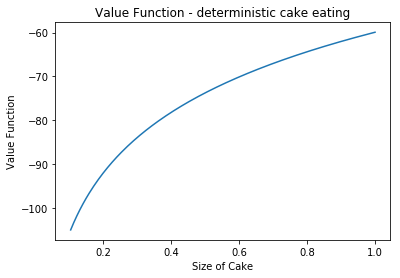

In [7]:
# Plot value function 
plt.figure()
plt.plot(w_grid[1:], VF[1:])
plt.xlabel('Size of Cake')
plt.ylabel('Value Function')
plt.title('Value Function - deterministic cake eating')
plt.show()

<Figure size 432x288 with 0 Axes>

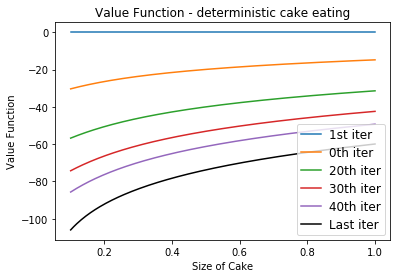

In [8]:
# Plot value function at several iterations
plt.figure()
fig, ax = plt.subplots()
ax.plot(w_grid, Vstore[:,0], label='1st iter')
ax.plot(w_grid, Vstore[:,10], label='0th iter')
ax.plot(w_grid, Vstore[:,20], label='20th iter')
ax.plot(w_grid, Vstore[:,30], label='30th iter')
ax.plot(w_grid, Vstore[:,40], label='40th iter')
ax.plot(w_grid, Vstore[:,VFiter-1], 'k', label='Last iter')
# Now add the legend with some customizations.
legend = ax.legend(loc='lower right', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Cake')
plt.ylabel('Value Function')
plt.title('Value Function - deterministic cake eating')
plt.show()

<Figure size 432x288 with 0 Axes>

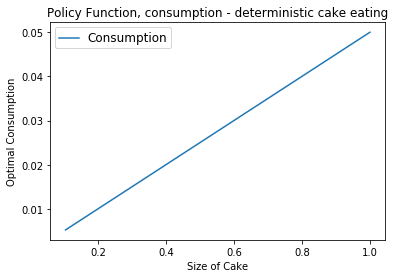

In [9]:
#Plot optimal consumption rule as a function of cake size
plt.figure()
fig, ax = plt.subplots()
ax.plot(w_grid[1:], optC[1:], label='Consumption')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Cake')
plt.ylabel('Optimal Consumption')
plt.title('Policy Function, consumption - deterministic cake eating')
plt.show()

<Figure size 432x288 with 0 Axes>

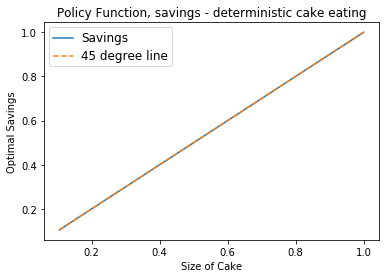

In [10]:
#Plot cake to leave rule as a function of cake size
plt.figure()
fig, ax = plt.subplots()
ax.plot(w_grid[1:], optW[1:], label='Savings')
ax.plot(w_grid[1:], w_grid[1:], '--', label='45 degree line')
# Now add the legend with some customizations.
legend = ax.legend(loc='upper left', shadow=False)
# Set the fontsize
for label in legend.get_texts():
    label.set_fontsize('large')
for label in legend.get_lines():
    label.set_linewidth(1.5)  # the legend line width
plt.xlabel('Size of Cake')
plt.ylabel('Optimal Savings')
plt.title('Policy Function, savings - deterministic cake eating')
plt.show()

## Finding approximation errors

It's a little complicated (we need to do the guess and verify method), but we can show that with $\sigma = 1.0$ (i.e., $u(c) = log(c)$), then the policy function is $w' = \beta w$.  Knowing this, we can find the approximation error from our solution method (VFI over a discrete grid).  This errors are found as:

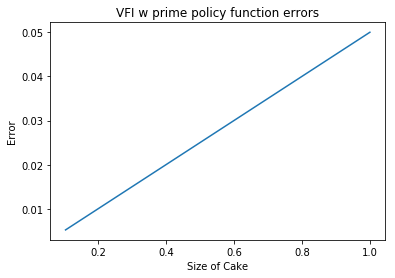

In [11]:
Wprime_errors = optW - beta * w_grid

# Plot policy function approximation errors
plt.figure()
plt.plot(w_grid[1:], Wprime_errors[1:])
plt.xlabel('Size of Cake')
plt.ylabel('Error')
plt.title('VFI w prime policy function errors')
plt.show()

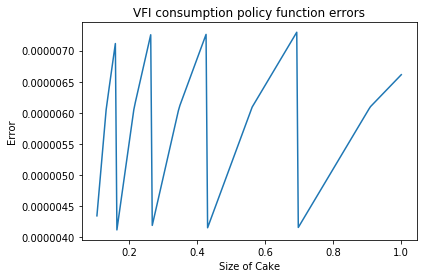

In [12]:
C_errors = optC - (1 - beta) * w_grid
# Plot policy function approximation errors
plt.figure()
plt.plot(w_grid[1:], C_errors[1:])
plt.xlabel('Size of Cake')
plt.ylabel('Error')
plt.title('VFI consumption policy function errors')
plt.show()

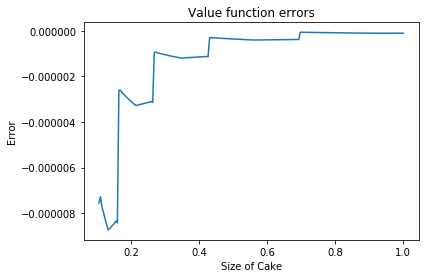

In [13]:
# Compute true value function if u(c)=log(c)
B = 1 / (1 - beta)
A = B * np.log(1 - beta) + B * B * beta * np.log(R * beta)
true_VF = A + B * np.log(w_grid)
VF_errors = VF - true_VF
# Plot value function approximation errors
plt.figure()
plt.plot(w_grid[1:], VF_errors[1:])
plt.xlabel('Size of Cake')
plt.ylabel('Error')
plt.title('Value function errors')
plt.show()

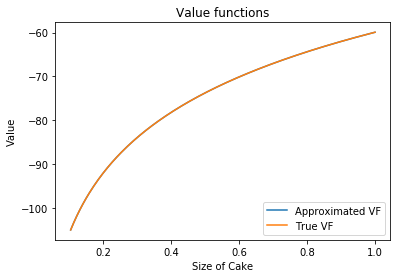

In [14]:
# Plot true and found value functions
plt.figure()
plt.plot(w_grid[1:], VF[1:], label='Approximated VF')
plt.plot(w_grid[1:], true_VF[1:], label='True VF')
plt.xlabel('Size of Cake')
plt.ylabel('Value')
plt.title('Value functions')
plt.legend(loc='lower right')
plt.show()